In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from svetlanna.phase_retrieval_problem import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna import LinearOpticalSetup
from svetlanna.units import ureg

# Phase retrieval problem

Consider an optical system consisting of a source generating a Gaussian beam, a collecting lens, and a screen located in the rear focal plane of the lens. 

First, let us solve the forward problem and see what intensity distribution will be obtained if a beam passes through such a system. Then let us solve the inverse problem using `svetlanna.phase_retrieval` module: knowing the intensity distribution on the screen after the passage of the optical system described above and the intensity distribution in the plane after the lens, let us try to find the transmission function of the lens

## Creating numerical mesh with using `SimulationParameters` class

In [188]:
# optical setup size
lx = 10 * ureg.mm
ly = 10 * ureg.mm

# number of nodes
Nx = 1024
Ny = 1024

# wavelength
wavelength = 1064 * ureg.nm

# focal distance of the lens
focal = 10 * ureg.cm
# radius of the lens
r = 1 * ureg.cm
# distance between the screen and the lens
distance = focal * 1.

# waist radius of the gaussian beam
w0 = 1 * ureg.mm

# creating SimulationParameters exemplar
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [189]:
# return 2d-tensors of x and y coordinates
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Solving a direct problem

In [190]:
incident_wavefront = Wavefront.gaussian_beam(
    simulation_parameters=sim_params,
    waist_radius=w0,
    distance=distance
)

source_intensity = incident_wavefront.intensity

lens = elements.ThinLens(
    simulation_parameters=sim_params,
    focal_length=focal,
    radius=r
)

field_after_lens = lens.forward(incident_wavefront=incident_wavefront)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=distance,
    method="AS"
)

output_field = free_space.forward(incident_wavefront=field_after_lens)

target_intensity = output_field.intensity

Creating optical setup that describes field propagation from source to the screen

In [191]:
optical_setup = LinearOpticalSetup([free_space])

## Solving phase retrieval problem

In order to solve the phase retrieval problem it's necessary to define the `source_intensity`,
`target_intensity` and optimization method in `phase_retrieval.retrieve_phase` function. Optionally, you can define algorithm's parameters using `options` parameter. You must pass the dict with key arguments

In [192]:
result_gs = phase_retrieval.retrieve_phase(
    source_intensity=source_intensity,
    optical_setup=optical_setup,
    target_intensity=target_intensity,
    method='GS',
    options= {
        'tol': 1e-16,
        'maxiter': 12,
        'disp': False
    }
)

In [193]:
phase_distribution_gs = result_gs.solution

niter_gs = result_gs.number_of_iterations

error_mass_gs = result_gs.cost_func_evolution

## Solving direct problem with founded phase profile

In [194]:
layer = elements.DiffractiveLayer(
    simulation_parameters=sim_params,
    mask=phase_distribution_gs
)

field_after_layer = layer.forward(incident_wavefront=incident_wavefront)
output_field_retrieved = free_space.forward(incident_wavefront=field_after_layer)

target_intensity_retrieved = output_field_retrieved.intensity

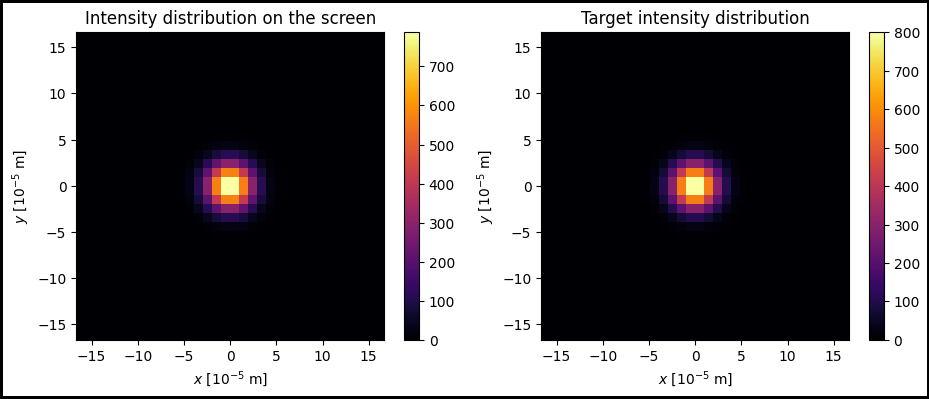

In [195]:
fig, ax = plt.subplots(
    1, 2, figsize=(11, 4), edgecolor='black', linewidth=3, frameon=True
)

scale_factor = 1e5
x_grid_scaled = x_grid * scale_factor
y_grid_scaled = y_grid * scale_factor

im1 = ax[0].pcolormesh(x_grid_scaled, y_grid_scaled, target_intensity_retrieved, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Intensity distribution on the screen')
ax[0].set_xlabel('$x$ [$10^{-5}$ m]')
ax[0].set_ylabel('$y$ [$10^{-5}$ m]')
ax[0].set_xlim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
ax[0].set_ylim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(x_grid_scaled, y_grid_scaled, target_intensity, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Target intensity distribution')
ax[1].set_xlabel('$x$ [$10^{-5}$ m]')
ax[1].set_ylabel('$y$ [$10^{-5}$ m]')
ax[1].set_xlim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
ax[1].set_ylim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
fig.colorbar(im2, ax=ax[1])

plt.show()

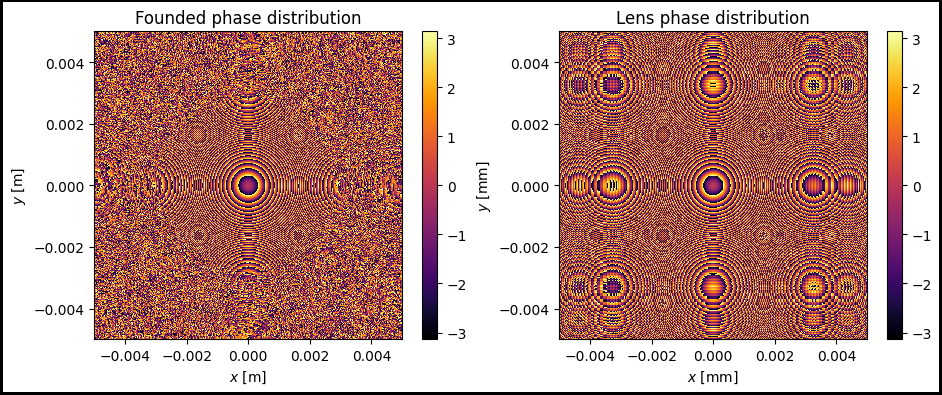

In [196]:
fig, ax = plt.subplots(
    1, 2, figsize=(11, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(x_grid, y_grid, phase_distribution_gs, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title('Founded phase distribution')
ax[0].set_xlabel('$x$ [m]')
ax[0].set_ylabel('$y$ [m]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(x_grid, y_grid, torch.real(torch.log(lens.transmission_function) / 1j), cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Lens phase distribution')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

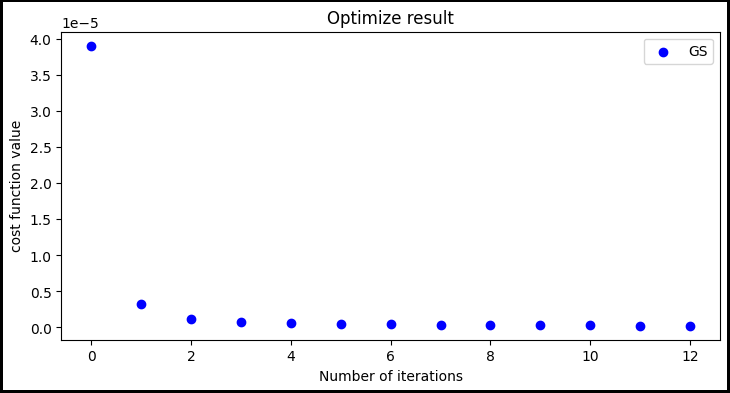

In [197]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)

ax.set_title(r'Optimize result')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('cost function value')

n_gs = np.arange(0, niter_gs+1)
ax.scatter(n_gs, error_mass_gs, label='GS', color='blue')

ax.legend()